# Set Up Spark

In [1]:
# Install necessary libraries
!pip install pyspark
!pip install python-dotenv

In [2]:
# Import necessary libraries
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
from matplotlib.cm import get_cmap
from matplotlib.ticker import FuncFormatter
from pyspark.sql.functions import explode, col, to_timestamp, substring, year
from pyspark.sql.types import StructType, StructField, StringType, LongType, BooleanType, ArrayType
from pyspark.sql import SparkSession

In [3]:
# Load environment variables for Azure access information
load_dotenv("credentials.env")

storage_account_name = os.getenv("AZURE_ACCOUNT_NAME")
storage_account_key = os.getenv("AZURE_STORAGE_KEY")
storage_container_name = "kaggle-datasets"
parquet_blob_name = "github-dataset-full.parquet"

In [4]:
# Creating Spark session
spark = SparkSession.builder \
    .appName("Read Parquet from Azure Blob Storage") \
    .config(f"spark.hadoop.fs.azure.account.key.{storage_account_name}.blob.core.windows.net", storage_account_key) \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.2,com.microsoft.azure:azure-storage:8.6.6") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Remove garbage error texts
spark.sparkContext.setLogLevel("ERROR")

:: loading settings :: url = jar:file:/opt/anaconda3/envs/naturalistvenv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/matthewleffler/.ivy2/cache
The jars for the packages stored in: /Users/matthewleffler/.ivy2/jars
org.apache.hadoop#hadoop-azure added as a dependency
com.microsoft.azure#azure-storage added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e1655cab-db05-41e3-a678-1b03b7a2c083;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-azure;3.3.2 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in local-m2-cache
	found org.apache.httpcomponents#httpcore;4.4.13 in local-m2-cache
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.11 in local-m2-cache
	found org.apache.hadoop.thirdparty#hadoop-shaded-guava;1.1.1 in central
	found org.eclipse.jetty#jetty-util-ajax;9.4.43.v20210629 in central
	found org.eclipse.jetty#jetty-util;9.4.43.v20210629 in central
	found org.codehaus.jackson#jackson-mapper-asl;1.9.13 in central
	found org.codehaus.jackson#jackson-core-asl;1.9.13 in centr

In [5]:
# Set authentification for Spark to connect to Azure
spark.conf.set(
    f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net",
    storage_account_key
)

# Load Data from Azure

In [6]:
# Read data to ensure data was properly saved
test_df = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/analytics/language_popularity"
)

# Create Charts

In [7]:
filtered_pandas_df = test_df.toPandas()

In [8]:
filtered_pandas_df

,year_month,repo_language,user_count
0,2018-02,Processing,331
1,2017-07,TypeScript,8111
2,2016-07,Go,4328
3,2016-02,JavaScript,45462
4,2017-04,Objective-C,6531
...,...,...,...
17907,2017-07,Parrot,1
17908,2010-03,Smalltalk,1
17909,2013-01,Nemerle,1
17910,2018-06,WebIDL,1


### Create Chart for Most Popular Language by Year

In [9]:
test_df.createOrReplaceTempView("popular_languages_view")

In [10]:
ranked_df = spark.sql("""
    WITH yearly_counts AS (
        SELECT 
            repo_language,
            YEAR(year_month) AS year,
            SUM(user_count) AS user_count
        FROM popular_languages_view
        GROUP BY repo_language, YEAR(year_month)
    )
    SELECT 
        repo_language,
        user_count,
        year,
        RANK() OVER (PARTITION BY year ORDER BY user_count DESC) AS lang_rank
    FROM yearly_counts
    ORDER BY year, lang_rank
""")

/var/folders/1t/jsm30br97550fyng6l_6zdv00000gn/T/ipykernel_69794/2963666151.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20", num_langs)


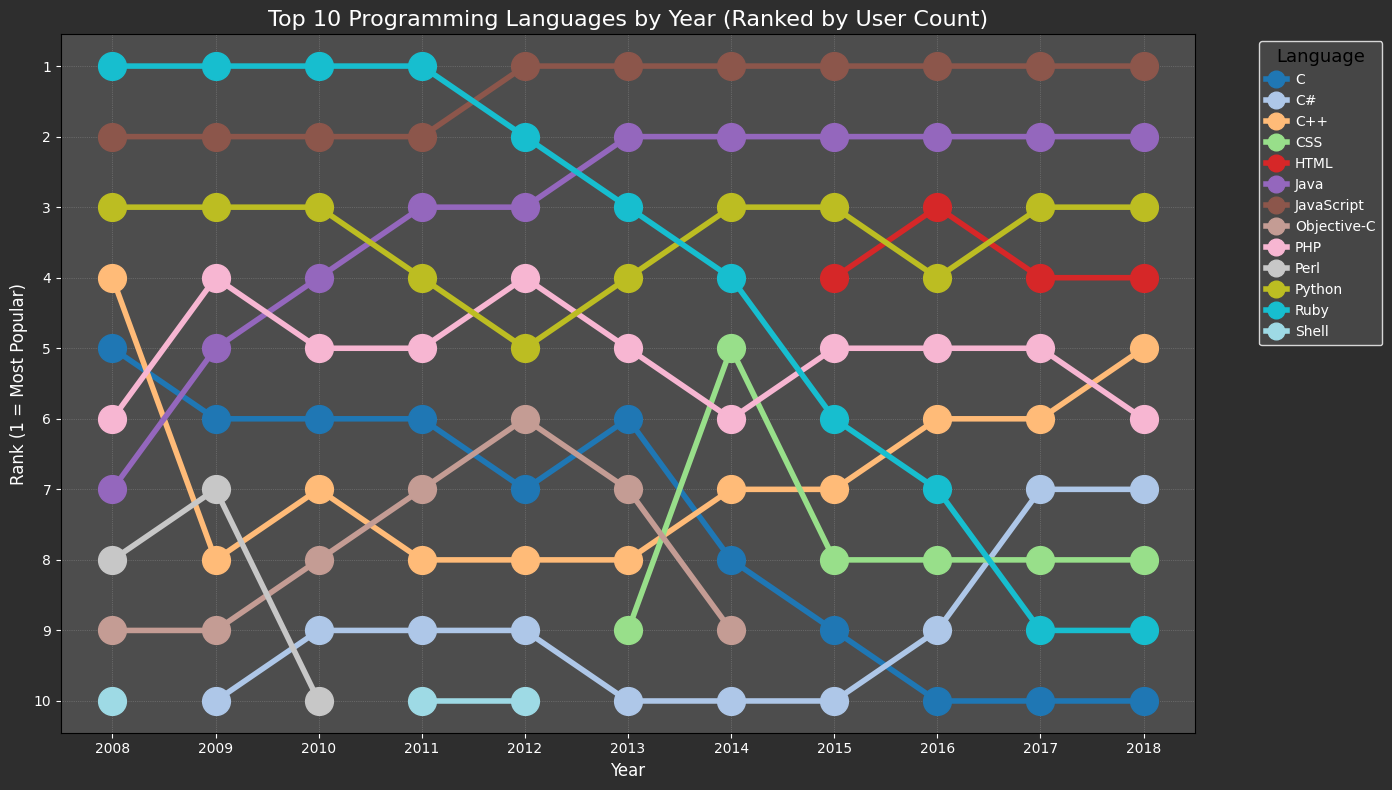

In [11]:
language_by_year_df = ranked_df.toPandas()

ranked = language_by_year_df.copy()

top10 = ranked[ranked['lang_rank'] <= 10].copy()
top10['lang_rank'] = top10['lang_rank'].astype(int)

pivot_df = top10.pivot(index='repo_language', columns='year', values='lang_rank')
pivot_df = pivot_df.dropna(how='all')
pivot_df = pivot_df.sort_index(axis=1)

unique_langs = list(pivot_df.index)
num_langs = len(unique_langs)
cmap = get_cmap("tab20", num_langs)
color_map = {lang: cmap(i) for i, lang in enumerate(unique_langs)}

plt.style.use("default")
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('#2e2e2e')    # Dark background
ax.set_facecolor('#4d4d4d')           # Darker plot area

for lang in unique_langs:
    ax.plot(
        pivot_df.columns,
        pivot_df.loc[lang],
        marker='o',
        linewidth=4,
        markersize=20,
        label=lang,
        color=color_map[lang]
    )

ax.invert_yaxis()
ax.set_xticks(pivot_df.columns)
ax.set_yticks(range(1, 11))
ax.set_title('Top 10 Programming Languages by Year (Ranked by User Count)', fontsize=16, color='white')
ax.set_xlabel('Year', fontsize=12, color='white')
ax.set_ylabel('Rank (1 = Most Popular)', fontsize=12, color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(color='gray', linestyle='dotted', linewidth=0.5)

ax.legend(
    title='Language',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    facecolor='#4d4d4d',
    edgecolor='white',
    labelcolor='white',
    title_fontsize='13',
    markerscale=0.6,
    handlelength=1.5,
    borderpad=0.5,
    handletextpad=0.6
)

plt.tight_layout()
plt.show()

### Create Chart for Trens of top 5 Language User Counts

In [12]:
top_languages_df = spark.sql("""
    SELECT repo_language, SUM(user_count) AS total_user_count
    FROM popular_languages_view
    GROUP BY repo_language
    ORDER BY total_user_count DESC
    LIMIT 5
""")

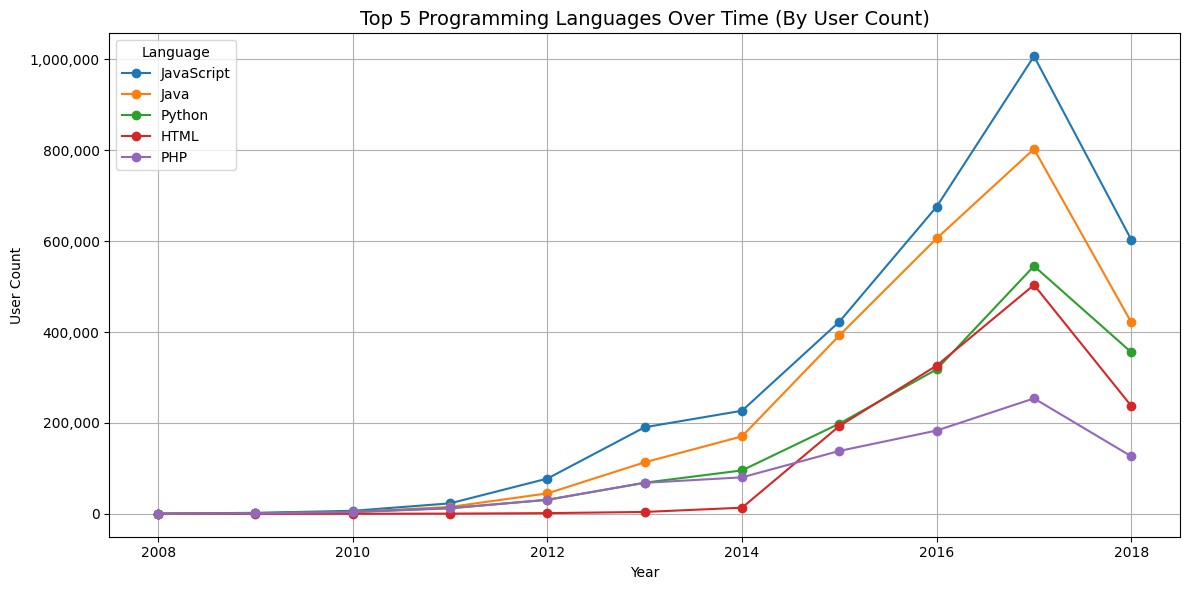

In [15]:
top_5_languages = [row['repo_language'] for row in top_languages_df.collect()]

language_yearly_df = (
    spark.table("popular_languages_view")
    .withColumn("year", year("year_month"))
    .filter(col("repo_language").isin(top_5_languages))
    .groupBy("year", "repo_language")
    .sum("user_count")
    .withColumnRenamed("sum(user_count)", "user_count")
    .orderBy("year")
)

language_yearly_pd = language_yearly_df.toPandas()

plt.figure(figsize=(12, 6))

for lang in top_5_languages:
    lang_data = language_yearly_pd[language_yearly_pd["repo_language"] == lang]
    plt.plot(lang_data["year"], lang_data["user_count"], marker='o', label=lang)

plt.title("Top 5 Programming Languages Over Time (By User Count)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("User Count")

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.legend(title="Language")
plt.grid(True)
plt.tight_layout()
plt.show()